In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/game-of-deep-learning-ship-datasets/test_ApKoW4T.csv
/kaggle/input/game-of-deep-learning-ship-datasets/sample_submission_ns2btKE.csv
/kaggle/input/game-of-deep-learning-ship-datasets/train/train.csv
/kaggle/input/game-of-deep-learning-ship-datasets/train/images/2213022.jpg
/kaggle/input/game-of-deep-learning-ship-datasets/train/images/2842076.jpg
/kaggle/input/game-of-deep-learning-ship-datasets/train/images/2862031.jpg
/kaggle/input/game-of-deep-learning-ship-datasets/train/images/2880224.jpg
/kaggle/input/game-of-deep-learning-ship-datasets/train/images/2821082.jpg
/kaggle/input/game-of-deep-learning-ship-datasets/train/images/2833446.jpg
/kaggle/input/game-of-deep-learning-ship-datasets/train/images/2847421.jpg
/kaggle/input/game-of-deep-learning-ship-datasets/train/images/2851911.jpg
/kaggle/input/game-of-deep-learning-ship-datasets/train/images/2794325.jpg
/kaggle/input/game-of-deep-learning-ship-datasets/train/images/725088.jpg
/kaggle/input/game-of-deep-learning-sh

In [2]:
data_csv = pd.read_csv('../input/game-of-deep-learning-ship-datasets/train/train.csv')
print('Data shape: ', data_csv.shape)

categories = {0: 'Cargo', 1:'Military', 2:'Carrier', 3:'Cruise', 4:'Tankers'}

# I want classes to start from 0. So I subtracted 1 from the categories
data_csv['category'] = data_csv['category'] - 1
data_csv['label'] = data_csv['category'].map(categories)
data_csv['label']  = pd.Categorical(data_csv['label'])
data_csv.head(5)

Data shape:  (6252, 2)


,image,category,label
0,2823080.jpg,0,Cargo
1,2870024.jpg,0,Cargo
2,2662125.jpg,1,Military
3,2900420.jpg,2,Carrier
4,2804883.jpg,1,Military


In [3]:
import cv2

path = '../input/game-of-deep-learning-ship-datasets/train/images/'

# List of image names
ilist = list(data_csv['image'])

data_img = []

for x in ilist:
    each_path = os.path.join(path, x)
    each_img = cv2.imread(each_path)
    each_img = cv2.cvtColor(each_img, cv2.COLOR_BGR2RGB)
    each_img_resized = cv2.resize(each_img, (128,128))
    data_img.append(each_img_resized)

# Converting list to numpy array
X = np.array(data_img)


In [4]:
from sklearn.preprocessing import OneHotEncoder
y = OneHotEncoder(dtype='int8', sparse=False).fit_transform(data_csv['category'].values.reshape(-1,1))

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


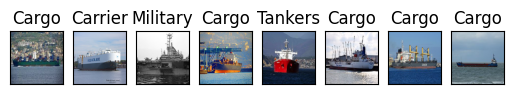

In [6]:
import matplotlib.pyplot as plt
indices = np.random.randint(0,6252,8) 
i = 1
plt.figure(figsize=(8,5))
for each in indices:
    plt.subplot(1,10,i)
    plt.imshow(X[each])
    plt.title(data_csv['label'].loc[each])
    plt.xticks([])
    plt.yticks([])
    i += 1

In [7]:
from sklearn.model_selection import train_test_split

X_data, X_test, y_data, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_data, y_data, test_size=0.2, random_state=42)

print('X_train shape: ', X_train.shape)
print('y_train shape: ', y_train.shape)
print('X_val shape  : ', X_val.shape)
print('y_val shape  : ', y_val.shape)
print('X_test shape : ', X_test.shape)
print('y_test shape : ', y_test.shape)

X_train shape:  (4000, 128, 128, 3)
y_train shape:  (4000, 5)
X_val shape  :  (1001, 128, 128, 3)
y_val shape  :  (1001, 5)
X_test shape :  (1251, 128, 128, 3)
y_test shape :  (1251, 5)


In [10]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_gen = ImageDataGenerator(horizontal_flip=True,
                               rotation_range = 45,
                               zoom_range=0.2,
                               height_shift_range = 0.5,
                               width_shift_range = 0.5)

validation_gen = ImageDataGenerator(horizontal_flip=True,
                               rotation_range = 45,
                               zoom_range=0.2,
                               height_shift_range = 0.5,
                               width_shift_range = 0.5)

train_gen.fit(X_train)
validation_gen.fit(X_val)

In [11]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPool2D, GlobalAveragePooling2D, Dropout
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.optimizers import Adam

# Defining batch and epoch sizes
batch_size = 100
epochs = 15

# Defining the pretrained base model
base = Xception(include_top=False, weights='imagenet', input_shape=(128,128,3))
x = base.output
x = GlobalAveragePooling2D()(x)
# Defining the head of the model where the prediction is conducted
head = Dense(5, activation='softmax')(x)
# Combining base and head 
model = Model(inputs=base.input, outputs=head)

# Compiling the model
model.compile(optimizer=Adam(lr=0.001), 
              loss = 'categorical_crossentropy', 
              metrics=['accuracy'])

# Fitting the model with train and validation augmented datasets.
history = model.fit_generator(train_gen.flow(X_train, y_train, batch_size=batch_size),
                              epochs = epochs,
                              validation_data = validation_gen.flow(X_val, y_val, batch_size=batch_size),
                              steps_per_epoch = X_train.shape[0] // batch_size)

83683744/83683744 [==============================] - 0s 0us/step


/tmp/ipykernel_42/4158419723.py:25: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_gen.flow(X_train, y_train, batch_size=batch_size),


Epoch 1/15
40/40 [==============================] - 56s 508ms/step - loss: 0.9557 - accuracy: 0.6265 - val_loss: 2.2533 - val_accuracy: 0.4905
Epoch 2/15
40/40 [==============================] - 20s 492ms/step - loss: 0.6220 - accuracy: 0.7623 - val_loss: 1.1885 - val_accuracy: 0.6743
Epoch 3/15
40/40 [==============================] - 20s 484ms/step - loss: 0.5079 - accuracy: 0.8067 - val_loss: 0.9674 - val_accuracy: 0.6633
Epoch 4/15
40/40 [==============================] - 19s 482ms/step - loss: 0.4947 - accuracy: 0.8115 - val_loss: 0.7586 - val_accuracy: 0.7263
Epoch 5/15
40/40 [==============================] - 19s 480ms/step - loss: 0.4151 - accuracy: 0.8388 - val_loss: 0.9832 - val_accuracy: 0.7243
Epoch 6/15
40/40 [==============================] - 20s 507ms/step - loss: 0.3931 - accuracy: 0.8508 - val_loss: 0.5186 - val_accuracy: 0.8072
Epoch 7/15
40/40 [==============================] - 20s 493ms/step - loss: 0.3664 - accuracy: 0.8668 - val_loss: 0.6679 - val_accuracy: 0.7972

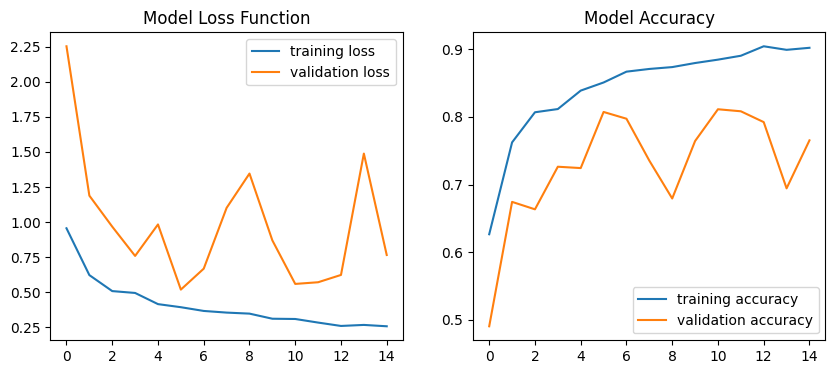

In [13]:
history_df = pd.DataFrame(history.history)

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(history_df['loss'], label='training loss')
plt.plot(history_df['val_loss'], label='validation loss')
plt.title('Model Loss Function')
plt.legend()
plt.subplot(1,2,2)
plt.plot(history_df['accuracy'], label='training accuracy')
plt.plot(history_df['val_accuracy'], label='validation accuracy')
plt.title('Model Accuracy')
plt.legend();


In [15]:
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis = 1)
y_test_classes = np.argmax(y_test, axis = 1)

40/40 [==============================] - 1s 23ms/step


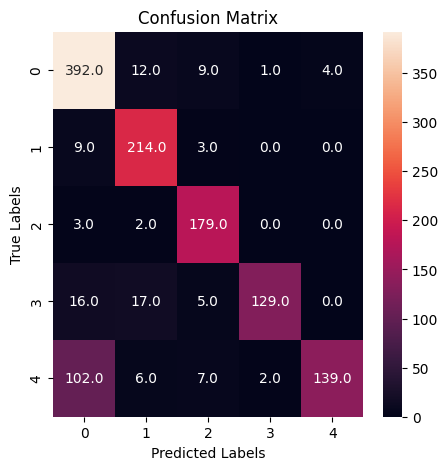

In [17]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
confmx = confusion_matrix(y_test_classes, y_pred_classes)
f, ax = plt.subplots(figsize = (5,5))
sns.heatmap(confmx, annot=True, fmt='.1f', ax = ax)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show();

In [18]:
print(classification_report(y_test_classes, y_pred_classes))

              precision    recall  f1-score   support

           0       0.75      0.94      0.83       418
           1       0.85      0.95      0.90       226
           2       0.88      0.97      0.93       184
           3       0.98      0.77      0.86       167
           4       0.97      0.54      0.70       256

    accuracy                           0.84      1251
   macro avg       0.89      0.83      0.84      1251
weighted avg       0.86      0.84      0.83      1251

